# Structure and complex prediction using Boltz

One of the challenges in structure prediction is structures of biomolecules interacting with other molecules, such as a enzyme bound to a substrate or a protein-DNA complex. With new methods such as [AlphaFold3](https://alphafoldserver.com/welcome) and the ever expanding structural data in the [Protein Data Bank](https://www.rcsb.org/), it is possible to (cautiously) model these complexes. Additionally, resources such as Google Colab (you are in one!) allow for greater access to these methods in scientific study.

**[Boltz-1](https://github.com/jwohlwend/boltz)** is a modeling algorithem built on AlphaFold3 that results in similar prediction quality. So why use it? The current iteration of the AlphaFold3 server (as of 2025) is highly restrained in the modeling options such as post-translational modifications and ligands. Boltz-1 has fewer restrictions on the options allowing for greater opportunity to model complexes.
This colab runs a version of Boltz-1 and reduces the input complexity to allow modeling of protein-ligand complexes. It is an adaptation of the notebook generated by the [Colabfold](https://github.com/sokrypton/ColabFold) group to make is accessible in the biochemistry classroom.

##**Please make a copy of this colab for your personal use!!**

A few things to start:

1.   These lessons only work in Google Chrome
2.   If you want to save your progress, go to File> Save a Copy in Drive; then locate a spot in your Drive folder
3.   Clicking the "play" button to the top left of a code block runs the code. Sometimes you can see the code and interact with it. However, if the code is hidden  it is to run adminstrative tasks in the background and you do not need to worry unless you are interested.



---

**A few notes:**
- Boltz-1 does not minimize structures after modeling and is known to produce overlapping chains or steric clashes in amino acids. If this is an issue, try modeling through another method or run an [MD simulation](https://colab.research.google.com/drive/1-Nr3oze1IWND4-eTci9TyykFhtx9fVuX?usp=sharing) to rectify issues.

- Long proteins or large complexes (~>2000 amino acids in total) may exceed the memory limits of the colab.



---
**Acknowledgements**

This Colab was adapted by Chris Berndsen at James Madison University (ver 2 2025) from a notebook written by [Colabfold](https://github.com/sokrypton/ColabFold) in 2024. The [Colabfold version of Boltz-1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/Boltz1.ipynb) offers more options than presented here.


# Getting started

To start modeling in Boltz, you need the sequence of your protein(s) in one letter amino acid code. If you are predicting a ligand bound complex you will also need the SMILES string(s), likely from [PubChem](https://pubchem.ncbi.nlm.nih.gov/).



1.   Paste your first protein sequence into the `query sequence` box
2.   If you have a multimeric protein, type a `:` after the first sequence and then paste in the next sequence. Repeat this until all protein sequences are in.
**NOTE:** You must have a sequence for each member of the complex, even if the protein is composed of multiple copies of the same protein.

3.   Add any ligands. If you are not predicting ligands, make sure the `ligand_input` section is completely blank except for the Insert text here.
4.   Press the play button. This step should take less than 10 seconds to run.




In [ ]:
#@title Input protein sequence(s)
from google.colab import files
import os
import re
import hashlib
import random
import requests
from string import ascii_uppercase

# Function to add a hash to the jobname
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# User inputs
query_sequence = 'MSEPIRVLVTGAAGQIAYSLLYSIGNGSVFGKDQPIILVLLDITPMMGVLDGVLMELQDCALPLLKDVIATDKEDVAFKDLDVAILVGSMPRREGMERKDLLKANVKIFKSQGAALDKYAKKSVKVIVVGNPANTNCLTASKSAPSIPKENFSCLTRLDHNRAKAQIALKLGVTANDVKNVIIWGNHSSTQYPDVNHAKVKLQGKEVGVYEALKDDSWLKGEFVTTVQQRGAAVIKARKLSSAMSAAKAICDHVRDIWFGTPEGEFVSMGVISDGNSYGVPDDLLYSFPVVIKNKTWKFVEGLPINDFSREKMDLTAKELTEEKESAFEFLSDA: MSEPIRVLVTGAAGQIAYSLLYSIGNGSVFGKDQPIILVLLDITPMMGVLDGVLMELQDCALPLLKDVIATDKEDVAFKDLDVAILVGSMPRREGMERKDLLKANVKIFKSQGAALDKYAKKSVKVIVVGNPANTNCLTASKSAPSIPKENFSCLTRLDHNRAKAQIALKLGVTANDVKNVIIWGNHSSTQYPDVNHAKVKLQGKEVGVYEALKDDSWLKGEFVTTVQQRGAAVIKARKLSSAMSAAKAICDHVRDIWFGTPEGEFVSMGVISDGNSYGVPDDLLYSFPVVIKNKTWKFVEGLPINDFSREKMDLTAKELTEEKESAFEFLSDA '  #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetero-oligomers). For example **PI...SK:PI...SK** for a homodimer
ligand_input = ''  #@param {type:"string"}
#@markdown  - Use `:` to specify multiple ligands as smile strings
##ligand_input_ccd = 'SAH'  #@param {type:"string"}
##@markdown - Use `:` to specify multiple ligands as CCD codes (three-letter codes)
##ligand_input_common_name = ''  #@param {type:"string"}
##@markdown - Use `:` to specify multiple ligands with their common name (e.g. Aspirin; SMILES fetched from [PubChem](https://pubchem.ncbi.nlm.nih.gov) API)
#dna_input = ''  #@param {type:"string"}
##@markdown - Use `:` to specify multiple DNA sequences
jobname = 'MimicBoltz_proj4'  #@param {type:"string"}

# Clean up the query sequence and jobname
query_sequence = "".join(query_sequence.split())
ligand_input = "".join(ligand_input.split())
#ligand_input_ccd = "".join(ligand_input_ccd.split())
#ligand_input_common_name = "".join(ligand_input_common_name.split())
#dna_input = "".join(dna_input.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# Check if a directory with jobname exists
def check(folder):
    return not os.path.exists(folder)

if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# Make directory to save results
os.makedirs(jobname, exist_ok=True)

from string import ascii_uppercase

# Split sequences on chain breaks
protein_sequences = query_sequence.strip().split(':') if query_sequence.strip() else []
ligand_sequences = ligand_input.strip().split(':') if ligand_input.strip() else []
#ligand_sequences_ccd = ligand_input_ccd.strip().split(':') if ligand_input_ccd.strip() else []
#ligand_sequences_common_name = ligand_input_common_name.strip().split(':') if ligand_input_common_name.strip() else []
#dna_sequences = dna_input.strip().split(':') if dna_input.strip() else []

def get_smiles(compound_name):
    autocomplete_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/autocomplete/compound/{compound_name}/json?limit=1"
    autocomplete_response = requests.get(autocomplete_url)
    if autocomplete_response.status_code != 200:
        return None

    autocomplete_data = autocomplete_response.json()
    if autocomplete_data.get("status", {}).get("code") != 0 or autocomplete_data.get("total", 0) == 0:
        return None

    suggested_compound = autocomplete_data.get("dictionary_terms", {}).get("compound", [])
    if not suggested_compound:
        return None
    suggested_compound_name = suggested_compound[0]

    smiles_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{suggested_compound_name}/property/CanonicalSMILES/JSON"
    smiles_response = requests.get(smiles_url)
    if smiles_response.status_code != 200:
        return None

    smiles_data = smiles_response.json()
    properties = smiles_data.get("PropertyTable", {}).get("Properties", [])
    if len(properties) == 0:
        return None

    return properties[0].get("CanonicalSMILES")

# Initialize chain labels starting from 'A'
chain_labels = iter(ascii_uppercase)

fasta_entries = []
csv_entries = []
chain_label_to_seq_id = {}
seq_to_seq_id = {}
seq_id_counter = 0  # Counter for unique sequences

# Process protein sequences
for seq in protein_sequences:
    seq = seq.strip()
    if not seq:
        continue  # Skip empty sequences
    chain_label = next(chain_labels)
    # Check if sequence has been seen before
    if seq in seq_to_seq_id:
        seq_id = seq_to_seq_id[seq]
    else:
        seq_id = f"{jobname}_{seq_id_counter}"
        seq_to_seq_id[seq] = seq_id
        seq_id_counter += 1
        # For CSV file (for ColabFold), add only unique sequences
        csv_entries.append((seq_id, seq))
    chain_label_to_seq_id[chain_label] = seq_id
    # For FASTA file
    msa_path = os.path.join(jobname, f"{seq_id}.a3m")
    header = f">{chain_label}|protein|{msa_path}"
    sequence = seq
    fasta_entries.append((header, sequence))

# Process ligand sequences (assumed to be SMILES strings)
for lig in ligand_sequences:
    lig = lig.strip()
    if not lig:
        continue  # Skip empty ligands
    chain_label = next(chain_labels)
    lig_type = 'smiles'
    header = f">{chain_label}|{lig_type}"
    sequence = lig
    fasta_entries.append((header, sequence))

# Write the CSV file for ColabFold
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write("id,sequence\n")
    for seq_id, seq in csv_entries:
        text_file.write(f"{seq_id},{seq}\n")

# Write the FASTA file
queries_fasta = os.path.join(jobname, f"{jobname}.fasta")
with open(queries_fasta, 'w') as f:
    for header, sequence in fasta_entries:
        f.write(f"{header}\n{sequence}\n")

# Optionally, print the output for verification
#print(f"Generated FASTA file '{queries_fasta}':\n")
#for header, sequence in fasta_entries:
#    print(f"{header}\n{sequence}\n")


In [ ]:
#@title Install dependencies
#@markdown This next step imports and installs the code necessary to run the prediction. No user inputs are needed and it should run in less than 5 minutes.
%%time
import os
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  else:
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.13")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if not os.path.isfile("BOLZ_READY"):
  os.system("apt-get install -y aria2")
  os.system("pip install -q --no-warn-conflicts boltz")
  os.system("mkdir weights")
  os.system("aria2c -d weights -x8 -s8 https://colabfold.steineggerlab.workers.dev/boltz1.ckpt")
  os.system("aria2c -d weights -x8 -s8 https://colabfold.steineggerlab.workers.dev/ccd.pkl")
  os.system("touch BOLZ_READY")

installing colabfold...
CPU times: user 657 ms, sys: 113 ms, total: 770 ms
Wall time: 3min 57s


## Multiple sequence alignment
One thing prediction methods use is an MSA or multiple sequence alignment to identify sequence conservation and co-evolution. This latter event comes from the idea that sequences that interact with each other co-evolve or change in complimentary ways to maintain the interaction site. Many sequences are needed and Boltz-1 uses the [mmseqs](https://github.com/soedinglab/MMseqs2) method to match and align many sequences. This method is similar to [NCBI BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi) but runs faster. Additionally, for predictions of complexes that are not homomers (meaning not composed of many of the same protein), the sequences have to be matched by taxonomy so that the co-evolution can be followed accurately.

This step runs in less than 5 minutes usually.

In [ ]:
#@title Generate MSA with ColabFold
!colabfold_batch "{queries_path}" "{jobname}" --msa-only

2025-04-15 14:13:15,341 Running colabfold 1.5.5 (bfc0e83d3b87730f6903f6c385b08c426d1e791e)

limited shared resource only capable of processing a few thousand MSAs per day. Please
submit jobs only from a single IP address. We reserve the right to limit access to the
server case-by-case when usage exceeds fair use. If you require more MSAs: You can 
precompute all MSAs with `colabfold_search` or host your own API and pass it to `--host-url`

2025-04-15 14:13:24,294 Running on GPU
2025-04-15 14:13:24,648 Found 4 citations for tools or databases
2025-04-15 14:13:24,648 Query 1/1: MimicBoltz_proj4_d7da3_0 (length 334)
2025-04-15 14:13:24,936 Sleeping for 7s. Reason: PENDING
2025-04-15 14:13:32,210 Sleeping for 5s. Reason: RUNNING
2025-04-15 14:13:37,483 Sleeping for 9s. Reason: RUNNING
2025-04-15 14:13:46,756 Sleeping for 8s. Reason: RUNNING
2025-04-15 14:13:55,029 Sleeping for 7s. Reason: RUNNING
2025-04-15 14:14:02,304 Sleeping for 6s. Reason: RUNNING
2025-04-15 14:14:08,570 Sleeping for 

# Predicting using Boltz-1

We are now ready to run Boltz-1 prediction. The algorithm will take the input information and the MSA and create a model of the biomolecule(s). While too complex to describe in this short box, effectively the workflow is to represent amino acids/ligands as tokens and progressively move these tokens in 3-D space until they result in a model which is reasonable from a protein structure standpoint. The system was trained on the information in the PDB and thus the constraints are based in reality. Thus, sequences and complexes for which there is existing or similar data will be predicted with higher confidence. Linked is a video which explores the [background on Boltz-1](https://youtu.be/mN5pXxRW4bA?si=4x4XtGIPTN469x6c) in more detail.

The time that this step takes varies a lot. In an example run, a homodimer of ~650 amino acids plus two ligands took about 15 minutes to run.

In [ ]:
#@title Predict structure using boltz
!boltz predict --out_dir "{jobname}" "{jobname}/{jobname}.fasta" --cache weights

Checking input data.
Running predictions for 1 structure
Processing input data.
100% 1/1 [00:00<00:00,  2.01it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-15 14:18:41.919907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100% 1/1 [06:03<00:00, 363.20s/it]Number of failed examples: 0
Predicting DataLoader 0: 100% 1/1 [06:03<00:00, 363.20s/it]
^C


# Visualizing the result
The next block will show the resulting model in 4 different ways:


*   Top left is the model colored by confidence.
*   Top right is the model in surface representation colored by confidence
*  Bottom left is model colored in rainbow in each
*  Bottom right is the model showing ligands as spheres


You can drag and rotate these structures and Zoom in on specific features if you wish.

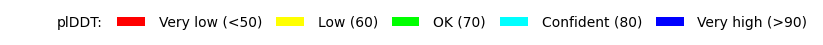

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
color = "lDDT"
show_sidechains = False


pdb_filename = os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.cif')
pdb_file = glob.glob(pdb_filename)

plot_plddt_legend().show()
model_name = jobname
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',viewergrid= (2,2))
view.addModel(open(pdb_file[0],'r').read(),'cif')
view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'ROYGB','min':50,'max':90}}}, viewer = (0,0))
view.setStyle({'cartoon': {'color':'spectrum'}}, viewer = (1,0))
view.setStyle({'cartoon': {'color':'white', 'width':'0.5'}}, viewer = (0,1))
BB = ['C', 'O', 'N']
view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                   {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}}, viewer= (0,1))
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'colorscheme': {'prop':'b','gradient': 'ROYGB','min':50,'max':90}}, viewer = (0,1))
view.setStyle({'cartoon': {'color':'grey'}}, viewer = (1,1))
view.setStyle({'resn':'LIG'}, {'sphere':{'colorscheme':'coralCarbon'}}, viewer = (1,1))

view.zoomTo()
view.render()



## Modeling Statistics

In addition the model, we also can see the statistics of the modeling. These scores are confidence scores in the structure, and if your modeled multiple molecules, the complex. These scores run from 0 to 1 with 0 meaning no confidence and 1 meaning perfect confidence.

This [site](https://neurosnap.ai/blog/post/interpreting-boltz-1-alphafold3-metrics-and-visualizations-on-neurosnap/675b7b92375d5ec1fde492ef) has more information on some of the statistics



### Scores

The main scores to look at when assessing the modeling are:

1.   Confidence score: Similar to the pLDDT score in AlphaFold3
2.   ipTM: interface predicted template modelling
3.   ligand_ipTM: interface predicted template modelling for ligand
4.   complex_pde: Predicted Docking Error describes uncertainty in 3-d arrangement of chains



### Are the data trustworthy?

*   Confidence score > 0.9: Very confident
*   0.9 > Confidence score > 0.8: Confident
*   0.8 > Confidence score > 0.6: Cautiously confident
*   0.6 > Confidence score > 0.5: Skeptical
*   Confidence score < 0.5: Try another method

For a biomolecule complex:

*  ipTM > 0.5: Likely on right track for complex



---


***Remember***, these models are trained on experimental structures, so if you are working with a sequence with similarity to known structures, you are almost guaranteed to get a decent score. This can complicate studies on mutants as the algorithm will always lean toward an existing structure over adapting to the sequence change. **Regardless of the scores, these are estimates and should be supported with experimental data whenever possible.**





In [ ]:
#@title Modeling statistics
#import pandas as pd
#json = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.json'))

#jsondf = pd.read_json(json[0])

#jsondf.to_csv(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, 'stats.csv'))

# remove the zeros from jsondf
#jsondf = jsondf.T
#jsondf = jsondf[jsondf[0] != 0]

#print(jsondf.to_string())

#@title Modeling statistics
import json
import csv
import glob
import os

def json_to_csv(json_file_path, csv_file_path):
    """
    Converts a JSON file to a CSV file.

    Args:
        json_file_path (str): The path to the JSON file.
        csv_file_path (str): The path to the CSV file to be created.
    """
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    if not data:
        print("JSON file is empty.")
        return

    if isinstance(data, dict):
        data = [data]

    with open(csv_file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        header = list(data[0].keys()) if data else []
        writer.writerow(header)

        for row in data:
            writer.writerow(row.values())


# Example usage:
# Get a list of JSON files using glob
json_files = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.json'))

# Iterate through the list and process each file
for json_file in json_files:  # Added loop to handle multiple JSON files
    csv_file = os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, 'stats.csv') # Output CSV file
    json_to_csv(json_file, csv_file)  # Pass the individual file path

print("Conversion completed.")

def print_csv_table(file_path):
    """Prints a CSV file as a formatted table."""
    with open(file_path, 'r') as file:
        reader = csv.reader(file)

        # Get the header row and calculate column widths
        header = next(reader)
        column_widths = [max(len(str(item)) for item in col) for col in zip(*([header] + list(reader)))]

        # Print the header
        for i, col in enumerate(header):
            print(f"{col:<{column_widths[i]}}", end="  ")
        print()
        print("-" * (sum(column_widths) + 4 * len(header))) # Print a separator line

        # Print the data rows
        file.seek(0) # Reset file pointer to beginning
        next(csv.reader(file)) # Skip header again
        for row in csv.reader(file):
            for i, item in enumerate(row):
                print(f"{item:<{column_widths[i]}}", end="  ")
            print()

# Example usage
file_path = os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, 'stats.csv')
print_csv_table(file_path)

Conversion completed.
confidence_score    ptm                 iptm                ligand_iptm  protein_iptm        complex_plddt      complex_iplddt      complex_pde         complex_ipde         chains_ptm                                          pair_chains_iptm                                                                                                    
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.9563887715339661  0.9608111381530762  0.9552507400512695  0.0          0.9552507400512695  0.956673264503479  0.9604831337928772  0.3095942735671997  0.36222612857818604  {'0': 0.9771942496299744, '1': 0.9772435426712036}  {'0': {'0': 0.9771942496299744, '1': 0.95522147

# Save your data!
This last step produces a compressed file called a .zip file containing 4 files:

1. the structural model in .cif format, the confidence of the relative placement of each amino acid can be see if the protein is colored by b-factor.
2. a parameters file in .yaml format
3. an image showing the number of sequences for each protein and the identity of the sequence
4.  an .a3m file which contains the sequences used in modeling

In [ ]:
#@title Download results
# Import necessary modules
import os
import zipfile
from google.colab import files
import glob

# Ensure 'jobname' variable is defined
# jobname = 'test_abcde'  # Uncomment and set if not already defined

# Name of the zip file
zip_filename = f"results_{jobname}.zip"

# Create a zip file and add the specified files without preserving directory structure
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    coverage_png_files = glob.glob(os.path.join(jobname, '*_coverage.png'))
    a3m_files = glob.glob(os.path.join(jobname, '*.a3m'))
    for file in coverage_png_files + a3m_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    cif_files = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.cif'))
    for file in cif_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    hparams_file = os.path.join(jobname, f'boltz_results_{jobname}', 'lightning_logs', 'version_0', 'hparams.yaml')
    if os.path.exists(hparams_file):
        arcname = os.path.basename(hparams_file)  # Use only the file name
        zipf.write(hparams_file, arcname=arcname)
    else:
        print(f"Warning: {hparams_file} not found.")

    json_files = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.json'))
    for file in json_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    csv_files = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.csv'))
    for file in csv_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

# Download the zip file
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Next steps
Much like AlphaFold3 models the .cif can be viewed in visualizing tools such a PyMOL or Mol*. These models are great for generating hypotheses to test in wet-lab experiments or for further modeling.

A few words of caution, modeling mutants and comparing the models to the prevalent sequence is difficult to do with modeling since the structure always pushes toward good quality protein structures. If you want to see the effects of a mutation computationally, you are encouraged to do molecular dynamics or similar techniques which move the atoms and look at relative stability. [One way to do MD](https://colab.research.google.com/drive/1-Nr3oze1IWND4-eTci9TyykFhtx9fVuX?usp=sharing).